##### Objective:
   * To identify fraudulent credit card transactions so that customers are not charged for items that they did not purchase.
   * To find new fraud patterns

#####  About The Data:
   * The datasets contains transactions made by credit cards in September 2013.These transactions occured in two days, and there are 429 frauds out of 284,807 transactions. 
   * PCA (Principal Component Analysis)- an unsupervised, non-parametric statistical technique is used for dimensionality reduction in machine learning. Features from v1 - v28 are the results of this PCA 
   * Other features (except 'Time' and 'Amount') are anonymized to protect the privacy of the customers.
   * Feature 'Time' is the time elapsed between each transaction and the first transaction
   * Feature 'Amount' depicts the amount of each transaction
   * Feature 'Class' is the dependent variable/target variable. 1 means fraudulent, and 0 means genuine.

##### Solutions:
   * Labeled data are based on historical experience, and it is hard to find unseen fraud patterns by using labeled data. Since unsupervised learning has no past knowledge, we can use unsupervised learning methods to find new fraud patterns
   * If an upcoming credit card transaction is not accepted by the trained HMM with high probability, it would be considered as fraud. Supervised and unsupervised machine learning techniques were combined to detect credit frauds. The results showed that the hybrid technique is efficient and could improve the accuracy of detection
   *  system for anomaly detection should NOT be a supervised ML algorithm as it will (maybe) learn only anomalies it has seen during training. The true magic lies in being able to identify an anomaly never seen before
   * As the data is very skewed - there are only 0.17% fraudulent transactions in the 280k samples - accuracy is not a good metric: any "model" predicting ALL are normal transactions will have a 99.83% accuracy.
   *  Use Recall, Precision and their prodigy (harmonic mean) - the F1 score. Try to optimize each model's hyperparameters for the best F1.
   * The models below do not take into account the time sequences, (while still having the time as a separate feature).The time series nature of the anomaly detection should be dealt with RNN or LSMT or etc. - maybe another notebook.
   * The training set does NOT include any Fraud, so when the model is exposed to one in Test, it will stand out from the normal transactions. I've tried dividing the Fraud half into a Validation subset and half in Test - F1 score being lower.

In [1]:
# Import neccessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# Load and display the first 5 rows of the creditcard transactions file
df = pd.read_csv('creditcard_transactions.csv')
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [3]:
# Remove the column "Unnamed: 0" because we don't need it
df.drop(columns = 'Unnamed: 0', inplace =True)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,64,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
1,64,-0.658305,0.406791,2.037461,-0.291298,0.147910,-0.350857,0.945373,-0.172560,0.025133,...,-0.156096,-0.238805,0.089877,0.421195,-0.352487,0.074783,-0.094192,-0.092493,54.99,0
2,124,1.105253,0.541842,0.839421,2.570933,-0.279517,-0.423062,0.088019,0.011622,-0.715756,...,-0.137434,-0.460991,0.189397,0.556329,0.185786,-0.189030,0.000208,0.026167,6.24,0
3,128,1.239495,-0.182609,0.155058,-0.928892,-0.746227,-1.235608,-0.061695,-0.125223,0.984938,...,0.146077,0.481119,-0.140019,0.538261,0.710720,-0.621382,0.036867,0.010963,8.80,0
4,132,-1.571359,1.687508,0.734670,1.293350,-0.217532,-0.002677,0.147364,0.515362,-0.372442,...,0.048549,0.377256,-0.030436,0.117608,-0.060520,-0.296550,-0.481570,-0.167897,10.00,0


In [4]:
# Calculate statistical data such as mean, std, min, percentiles using .describe() method
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,95357.290375,0.016628,-0.005726,-0.010398,-0.028731,-0.022065,0.000739,0.016121,-0.004941,-0.013924,...,-0.003501,0.028278,0.006422,-0.000855,-0.000284,0.000740,-0.006161,0.005893,89.669246,0.002125
std,46956.240862,1.899212,1.545809,1.477050,1.426184,1.401964,1.332905,1.305012,1.174568,1.106161,...,0.678019,0.714746,0.553929,0.606846,0.513374,0.485101,0.394584,0.348770,260.188804,0.046052
min,64.000000,-29.973363,-29.198899,-19.947726,-5.416315,-40.427726,-7.810116,-21.234463,-26.069936,-8.739670,...,-13.950186,-4.910197,-12.667179,-2.814898,-3.223535,-1.511259,-5.809357,-3.693525,0.000000,0.000000
25%,55189.750000,-0.915243,-0.610001,-0.893566,-0.903137,-0.714806,-0.790640,-0.560447,-0.215935,-0.653245,...,-0.221765,-0.519427,-0.159989,-0.345288,-0.311490,-0.327823,-0.071358,-0.052957,5.990000,0.000000
50%,85758.000000,0.025737,0.040064,0.165369,-0.035525,-0.076317,-0.282476,0.043119,0.019278,-0.057401,...,-0.026597,0.031274,-0.008716,0.038126,0.023790,-0.061720,0.000514,0.011239,22.855000,0.000000
75%,139042.750000,1.321858,0.784179,0.991859,0.752604,0.601602,0.403259,0.581711,0.331131,0.594168,...,0.191495,0.549468,0.144751,0.440633,0.344371,0.246298,0.086333,0.076835,78.432500,0.000000
max,172766.000000,2.373022,11.447082,3.985446,9.074932,13.815072,23.917837,44.054461,9.561121,7.938980,...,14.507345,4.222704,19.228169,3.577753,2.520869,2.693658,5.352193,15.649134,10199.440000,1.000000


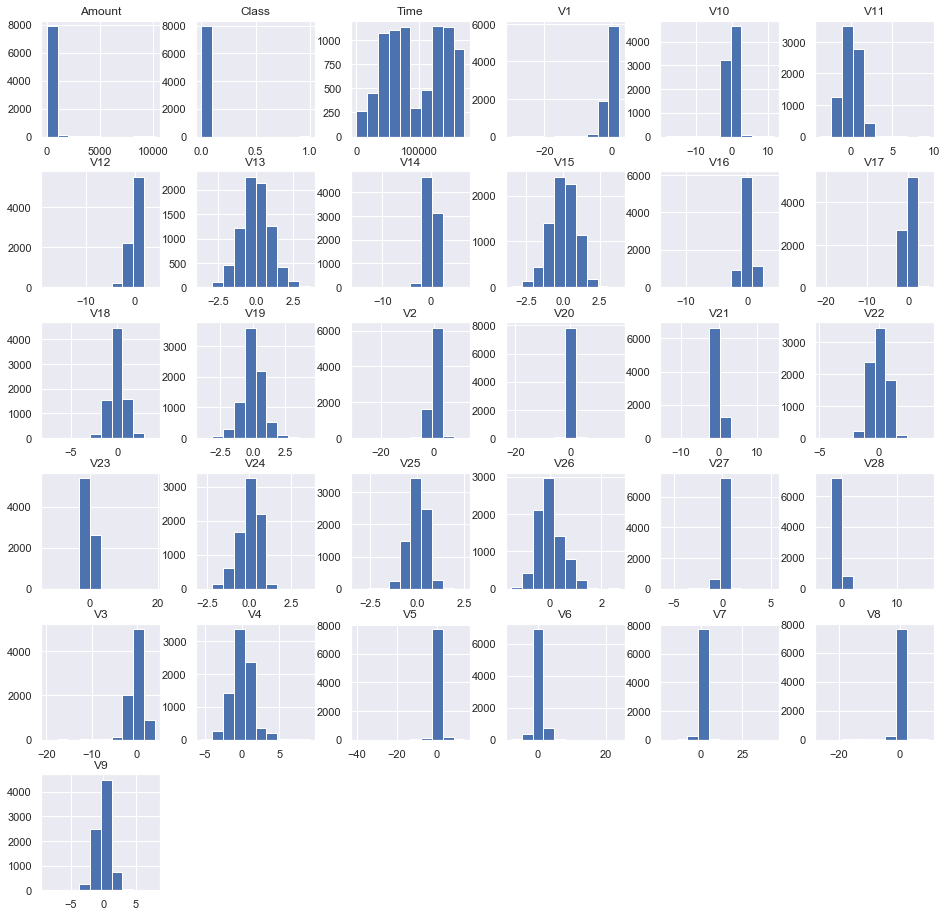

In [5]:
# Plot data distribution for each feature in the dataset
df.hist(figsize=(16,16))
plt.show()

##### Annotation:
* There are two columns in the 'Amount' feature. We can assume that the tall - dominant column is associated with the valid transactions whereas the very low-barely notice column is corresponding with the fraudulent transactions
* There should be two columns in the 'Class' feature. The number of frauds isn't showed due to its significantly small compare to the number of valid transactions
* Time is measured in seconds. The parabolas shape indicates many transactions occur at the same time
* Some of the Vs - PCA components have some what skew and bell shape. The x variable expands in both negative and postive regions

Text(0.5, 1, 'Correlation Heatmap')

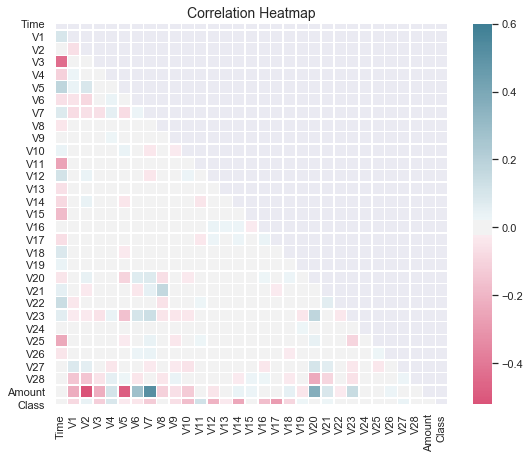

In [56]:
# create the correlation heatmap
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axs = plt.subplots(figsize=(9, 7))

cmap = sns.diverging_palette(1,222, as_cmap=True)

sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.6,
            center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": 1});
plt.title('Correlation Heatmap', fontsize =14)

##### What we have learned from this Correlation Heatmap:
* None of the V1 to V28 has any correlation to each other
* 'Class' don't have any correlation with 'Amount' or 'Time', but it does have some form of positive and negative (mostly low negative) correlations with the 'V' components
* 'Amount' does have some high positive correlations with V7 and V20, and high negative correlations with the V2 and V5 components
* We can safely focus on the three main features: Class, Amount, and Time

In [7]:
# Check for number of frauds vs number of normal transactions 
df_class = df['Class'].value_counts()
df_class
print(f"The number of Valid Transactions is: {df_class[0]}")
print(f"The number of Fraud Transactions is: {df_class[1]}")

The number of Valid Transactions is: 7983
The number of Fraud Transactions is: 17


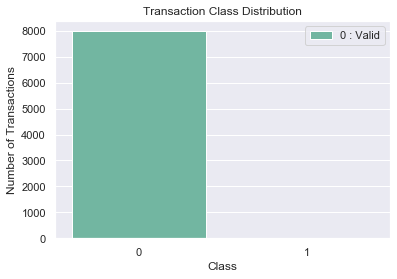

In [8]:
# use bar plot to visualize the higly unbalance in "Class" feature
ax = sns.countplot(x="Class",data=df, palette="Set2")
plt.title('Transaction Class Distribution')
plt.ylabel('Number of Transactions')
plt.legend(['0 : Valid','1: Fraud'])

##### Notes:
* There are 17 fraud transactions out of 8000 transactions during 2 consecutive days in September.
* This highly unbalance with respect to target variable 'Class' needs to be treated before any further data processing.

In [48]:
# Define the dataframe for fraud and normal classes
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

In [52]:
# Plot Fraudulent Transactions Trending over Time
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=round(fraud['Time']/3600,2), y=round(fraud['Amount'],2),
                    mode='lines+markers'))
fig.update_layout(title_text='Fraudulent Transactions Trend',
                  xaxis_title='Time(in Hours)',
                  yaxis_title='Amount',
                  plot_bgcolor='rgb(250, 242, 242)', 
                  font=dict(family="Courier New, monospace",
                  size=18,))
fig.update_layout(
    title={
        'text': "Fraudulent Transactions Trend",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [49]:
# Plot Valid Transaction Trending over Time-in hours
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=round(normal['Time']/3600,2), y=round(normal['Amount'],2),
                    mode='lines+markers'))
fig.update_layout(title_text='Valid Transactions Trend',
                  xaxis_title='Time(in Hours)',
                  yaxis_title='Amount',
                  plot_bgcolor='rgb(250, 242, 242)', 
                  font=dict(family="Courier New, monospace", size=18,))

fig.update_layout(
    title={
        'text': "Valid Transactions Trend",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()